In [1]:
import os
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from superbit_lensing.utils import get_cluster_info
from scipy.ndimage import gaussian_filter

In [2]:
cluster_name = 'Abell1689'
bands = 'b', 'g'
datadir = "/work/mccleary_group/saha/data" #Change to your data directory!

In [3]:
delz = 0.02

# X-ray center coordinates
ra_center, dec_center, redshift = get_cluster_info(cluster_name)

base_path = os.path.join(datadir, cluster_name)
color_mag_file = os.path.join(datadir, f'{cluster_name}/sextractor_dualmode/out/{cluster_name}_colors_mags.fits')

cm_cat = Table.read(color_mag_file)

m_b = cm_cat["m_b"]
m_g = cm_cat["m_g"]
color_index = cm_cat["color_bg"]

z = cm_cat['Z_best']
z_matched = z[~np.isnan(z)]
matched_data_b_ned = cm_cat[~np.isnan(z)]

# Step 5: Classify NED Matches by Redshift
cluster_redshift = redshift
cluster_redshift_up = cluster_redshift + delz
cluster_redshift_down = cluster_redshift - delz

high_z_indices = np.where(z_matched > cluster_redshift_up)[0]
low_z_indices = np.where(z_matched <= cluster_redshift_down)[0]
mid_z_indices = np.where((z_matched > cluster_redshift_down) & (z_matched <= cluster_redshift_up))[0]

high_z_b = matched_data_b_ned[high_z_indices]
low_z_b = matched_data_b_ned[low_z_indices]
mid_z_b = matched_data_b_ned[mid_z_indices]

print(f"Galaxies with z > {cluster_redshift_up:0.2f}: {len(high_z_indices)}")
print(f'Galaxies with {cluster_redshift_down:0.2f} < z ≤ {cluster_redshift_up:0.2f}: {len(mid_z_indices)}')
print(f"Galaxies with z ≤ {cluster_redshift_down:0.2f}: {len(low_z_indices)}")

color_index_high = high_z_b["color_bg"]
m_b_high = high_z_b["m_b"]
color_index_mid = mid_z_b["color_bg"]
m_b_mid = mid_z_b["m_b"]
color_index_low = low_z_b["color_bg"]
m_b_low = low_z_b["m_b"]

Galaxies with z > 0.20: 218
Galaxies with 0.16 < z ≤ 0.20: 134
Galaxies with z ≤ 0.16: 28


Number of objects in the red sequence: 581


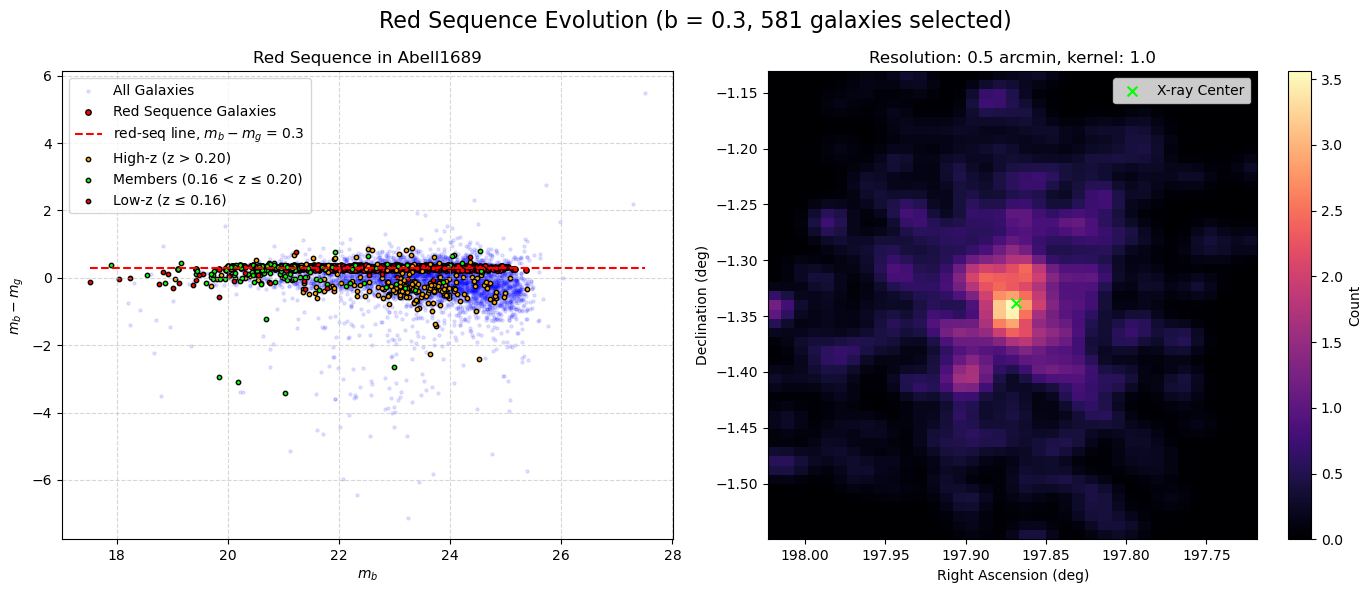

In [9]:
a = 0.0
b = 0.3
tolerance = 0.07

ra_max, ra_min, dec_max, dec_min = np.max(cm_cat["ra"]), np.min(cm_cat["ra"]), np.max(cm_cat["dec"]), np.min(cm_cat["dec"])
ra_center_inverted = ra_max + ra_min - ra_center

# Compute red sequence mask
predicted_color = a * m_b + b
red_sequence_mask = np.abs(color_index - predicted_color) < tolerance
print(f"Number of objects in the red sequence: {np.sum(red_sequence_mask)}")

# Extract red sequence galaxy positions
ra_red = cm_cat["ra"][red_sequence_mask]
dec_red = cm_cat["dec"][red_sequence_mask]

# Define RA and Dec boundaries
resolution = 0.5  # arcmin
n_bins_ra = int(np.ceil((ra_max - ra_min) * 60 / resolution))
n_bins_dec = int(np.ceil((dec_max - dec_min) * 60 / resolution))

# Create the 2D histogram (pixelated count of objects)
hist, xedges, yedges = np.histogram2d(ra_red, dec_red, bins=[n_bins_ra, n_bins_dec])

# Apply Gaussian smoothing
sigma = 1.
smoothed_hist = gaussian_filter(hist, sigma=sigma)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Color-Magnitude Diagram
axes[0].scatter(m_b, color_index, s=5, alpha=0.1, color='blue', label="All Galaxies")
axes[0].scatter(m_b[red_sequence_mask], color_index[red_sequence_mask], s=15, color='red', edgecolors='black', label="Red Sequence Galaxies")
m_b_range = np.linspace(min(m_b), max(m_b), 100)
axes[0].plot(m_b_range, a * m_b_range + b, color='red', linestyle='--', label=f"red-seq line, $m_b - m_g$ = {b}")
axes[0].scatter(m_b_high, color_index_high, s=10, edgecolors='black', facecolors='orange', label=f'High-z (z > {cluster_redshift_up:.2f})')
axes[0].scatter(m_b_mid, color_index_mid, s=10, edgecolors='black', facecolors='lime', label=f'Members ({cluster_redshift_down:.2f} < z ≤ {cluster_redshift_up:.2f})')
axes[0].scatter(m_b_low, color_index_low, s=10, edgecolors='black', facecolors='red', label=f'Low-z (z ≤ {cluster_redshift_down:.2f})')
axes[0].set_xlabel(r"$m_b$")
axes[0].set_ylabel(r"$m_b - m_g$")
axes[0].set_title(f"Red Sequence in {cluster_name}")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Second plot: Spatial distribution of red-sequence galaxies
im = axes[1].imshow(smoothed_hist.T[:, ::-1], origin='lower', aspect='auto', cmap='magma',
                    extent=[ra_max, ra_min, dec_min, dec_max])
axes[1].scatter(ra_center_inverted, dec_center, color='lime', marker='x', s=50, label="X-ray Center")
axes[1].set_xlabel("Right Ascension (deg)")
axes[1].set_ylabel("Declination (deg)")
axes[1].set_title(f"Resolution: {resolution} arcmin, kernel: {sigma}")
axes[1].legend()
fig.colorbar(im, ax=axes[1], label="Count")
n_red_seq = np.sum(red_sequence_mask)
fig.suptitle(f"Red Sequence Evolution (b = {b:.1f}, {n_red_seq} galaxies selected)", 
                fontsize=16)
# Show plots
plt.tight_layout()
plt.show()

In [6]:
red_seq_galaxies = cm_cat[red_sequence_mask]
out_filename = f"{base_path}/{bands[0]}/coadd/{cluster_name}_coadd_redseq.fits"
red_seq_galaxies.write(out_filename, format='fits', overwrite=True)

print(f"Red sequence catalog saved as {out_filename}")

red_seq_galaxies = cm_cat[red_sequence_mask]
out_filename = f"{base_path}/{bands[1]}/coadd/{cluster_name}_coadd_redseq.fits"
red_seq_galaxies.write(out_filename, format='fits', overwrite=True)

print(f"Red sequence catalog saved as {out_filename}")

Red sequence catalog saved as /work/mccleary_group/saha/data/Abell1689/b/coadd/Abell1689_coadd_redseq.fits
Red sequence catalog saved as /work/mccleary_group/saha/data/Abell1689/g/coadd/Abell1689_coadd_redseq.fits
